<h2 align="center" style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">Time-Series Forecasting in Financial Markets: Integrating Attention Mechanisms with Traditional Neural Networks for High-Frequency Trading Data</h2>

### **Table of Contents**

- [Introduction](#Introduction)
   - Research Overview
   - Objectives
   - Data Source and Storage
- [Install and Import Required Libraries](#Install-and-Import-Required-Libraries)
- [Download and Load Dataset](#Download-and-Load-Dataset)
- [Data Exploration](#Data-Exploration)
   - View First Five Rows
   - Inspect Shape
   - Investigate Missing data, duplicates and so on

<h3 style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">Introduction</h3>

### Research Overview

### Objectives

### Data Source and Storage

<h3 style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">Install and Import Required Libraries</h3>

In [1]:
!pip install --upgrade -q yfinance
!pip install -q pyspark pandas
!pip install -q -U kaleido

In [2]:
import yfinance as yf

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType, DateType

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

<h3 style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">Download and Load Dataset</h3>

#### Download and Store Finance Data using Y-Finance API

In [3]:
# Initialize PySpark session
spark = SparkSession.builder.appName("StockDataStorage").getOrCreate()

# Define stock symbols
stocks = ["GOOG", "AMZN", "MSFT", "TSLA"]

In [4]:
# Define schema (Date as String initially, to convert later)
schema = StructType([
    StructField("Date", StringType(), True),  # Initially store as String
    StructField("Open", DoubleType(), True),
    StructField("High", DoubleType(), True),
    StructField("Low", DoubleType(), True),
    StructField("Close", DoubleType(), True),
    StructField("Adj Close", DoubleType(), True),
    StructField("Volume", IntegerType(), True),
    StructField("Dividends", DoubleType(), True),
    StructField("Stock_Splits", DoubleType(), True),
])

In [5]:
def download_stock_data(storage_path = "pyspark_stock_data/"):
    # Fetch, store, and load data
    for stock in stocks:
        # Fetch max available stock data with 1-day interval
        dat = yf.Ticker(stock)
        df = dat.history(period="max", interval="1d", end="2025-02-28", auto_adjust=False)
    
        # Reset index to move Date column
        df.reset_index(inplace=True)
        
        # Convert Date column to string (YYYY-MM-DD format)
        df["Date"] = df["Date"].dt.strftime("%Y-%m-%d")
        
        # Convert to PySpark DataFrame
        spark_df = spark.createDataFrame(df, schema=schema)
    
        # Convert Date column to actual DateType()
        spark_df = spark_df.withColumn("Date", spark_df["Date"].cast(DateType()))
    
        # Save as Parquet
        stock_path = f"{storage_path}{stock}.parquet"
        spark_df.write.mode("overwrite").parquet(stock_path)
        
        print(f"Stored {stock} data at {stock_path}")

In [6]:
storage_path = "pyspark_stock_data/"
# download_stock_data(storage_path)

#### Load Saved PySpark Data 

In [7]:
# Load data into separate variables and sort by Date
goog_df = spark.read.parquet(f"{storage_path}GOOG.parquet").orderBy(col("Date"))
amzn_df = spark.read.parquet(f"{storage_path}AMZN.parquet").orderBy(col("Date"))
msft_df = spark.read.parquet(f"{storage_path}MSFT.parquet").orderBy(col("Date"))
tsla_df = spark.read.parquet(f"{storage_path}TSLA.parquet").orderBy(col("Date"))

<h3 style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">Data Exploration</h3>

#### **Viewing First 5 Rows of Each DataFrame**

In [8]:
print("GOOG Data:")
goog_df.show(5, truncate=False)

print("\nAMZN Data:")
amzn_df.show(5, truncate=False)

print("\nMSFT Data:")
msft_df.show(5, truncate=False)

print("\nTSLA Data:")
tsla_df.show(5, truncate=False)

GOOG Data:
+----------+------------------+------------------+------------------+------------------+------------------+---------+---------+------------+
|Date      |Open              |High              |Low               |Close             |Adj Close         |Volume   |Dividends|Stock_Splits|
+----------+------------------+------------------+------------------+------------------+------------------+---------+---------+------------+
|2004-08-19|2.490664005279541 |2.591784954071045 |2.3900420665740967|2.4991331100463867|2.4901857376098633|897427216|0.0      |0.0         |
|2004-08-20|2.515820026397705 |2.7168169021606445|2.5031180381774902|2.697638988494873 |2.6879806518554688|458857488|0.0      |0.0         |
|2004-08-23|2.758410930633545 |2.8264060020446777|2.7160699367523193|2.7247869968414307|2.715031623840332 |366857939|0.0      |0.0         |
|2004-08-24|2.7706151008605957|2.779581069946289 |2.5795810222625732|2.611959934234619 |2.6026086807250977|306396159|0.0      |0.0         |
|2

#### **Statistical Summary of Each DataFrame**

In [9]:
print("GOOG Statistical Summary:")
goog_df.describe().show()

print("\nAMZN Statistical Summary:")
amzn_df.describe().show()

print("\nMSFT Statistical Summary:")
msft_df.describe().show()

print("\nTSLA Statistical Summary:")
tsla_df.describe().show()

GOOG Statistical Summary:
+-------+------------------+------------------+------------------+-----------------+-----------------+--------------------+--------------------+--------------------+
|summary|              Open|              High|               Low|            Close|        Adj Close|              Volume|           Dividends|        Stock_Splits|
+-------+------------------+------------------+------------------+-----------------+-----------------+--------------------+--------------------+--------------------+
|  count|              5165|              5165|              5165|             5165|             5165|                5165|                5165|                5165|
|   mean| 48.93990213342465| 49.45671206540775|48.449156268083804|48.95874818776953|48.79813590631365|1.1302206754946756E8|1.161665053242981...|0.004453968151016456|
| stddev|47.978757301367004| 48.50769133322562| 47.50290344457604|48.00341270783708|47.87208504893696| 1.485536280031548E8|0.004819159977085381|

#### **Checking for Missing Values**

In [10]:
def check_missing_values(df, name):
    print(f"\nMissing Values in {name}:")
    df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

# Check for missing values in each stock dataset
check_missing_values(goog_df, "GOOG")
check_missing_values(amzn_df, "AMZN")
check_missing_values(msft_df, "MSFT")
check_missing_values(tsla_df, "TSLA")


Missing Values in GOOG:
+----+----+----+---+-----+---------+------+---------+------------+
|Date|Open|High|Low|Close|Adj Close|Volume|Dividends|Stock_Splits|
+----+----+----+---+-----+---------+------+---------+------------+
|   0|   0|   0|  0|    0|        0|     0|        0|           0|
+----+----+----+---+-----+---------+------+---------+------------+


Missing Values in AMZN:
+----+----+----+---+-----+---------+------+---------+------------+
|Date|Open|High|Low|Close|Adj Close|Volume|Dividends|Stock_Splits|
+----+----+----+---+-----+---------+------+---------+------------+
|   0|   0|   0|  0|    0|        0|     0|        0|           0|
+----+----+----+---+-----+---------+------+---------+------------+


Missing Values in MSFT:
+----+----+----+---+-----+---------+------+---------+------------+
|Date|Open|High|Low|Close|Adj Close|Volume|Dividends|Stock_Splits|
+----+----+----+---+-----+---------+------+---------+------------+
|   0|   0|   0|  0|    0|        0|     0|        0

### **Initial Data Exploration Summary**

#### **1. Google (GOOG) Data**
- **Date Range**: The data for Google spans from **2004-08-19** to **2025-02-28**.
- **Missing Values**: There are **no missing values** in any of the columns (`Date`, `Open`, `High`, `Low`, `Close`, `Volume`, `Dividends`, `Stock_Splits`).
- **Statistical Summary**:
  - The average opening price is **\$48.80**, with a minimum of **\$2.48** and a maximum of **\$204.50**.
  - The average daily trading volume is **113,006,001** shares.
  - Dividends and stock splits are rare, with most values being **0.0**.

#### **2. Amazon (AMZN) Data**
- **Date Range**: The data for Amazon spans from **1997-05-15** to **2025-02-28**.
- **Missing Values**: There are **no missing values** in any of the columns.
- **Statistical Summary**:
  - The average opening price is **\$40.82**, with a minimum of **\$0.07** and a maximum of **\$239.02**.
  - The average daily trading volume is **135,991,203** shares.
  - Dividends are consistently **0.0**, and stock splits are rare.

#### **3. Microsoft (MSFT) Data**
- **Date Range**: The data for Microsoft spans from **1986-03-13** to **2025-02-28**.
- **Missing Values**: There are **no missing values** in any of the columns.
- **Statistical Summary**:
  - The average opening price is **\$57.97**, with a minimum of **\$0.05** and a maximum of **\$464.30**.
  - The average daily trading volume is **56,247,171** shares.
  - Dividends are present, with an average of **\$0.003** per share, and stock splits are rare.

#### **4. Tesla (TSLA) Data**
- **Date Range**: The data for Tesla spans from **2010-06-29** to **2025-02-28**.
- **Missing Values**: There are **no missing values** in any of the columns.
- **Statistical Summary**:
  - The average opening price is **\$84.67**, with a minimum of **\$1.08** and a maximum of **\$475.90**.
  - The average daily trading volume is **96,491,526** shares.
  - Dividends are consistently **0.0**, and stock splits are rare.

---

### **Key Observations**
1. **Date Range**:
   - The datasets cover different time periods, with **Microsoft (MSFT)** having the longest history (since 1986) and **Tesla (TSLA)** having the shortest (since 2010).
   - All datasets are consistent up to **2025-02-28**, ensuring uniformity in the analysis.

2. **Missing Values**:
   - There are **no missing values** in any of the datasets, indicating that the data is clean and complete.

3. **Price Trends**:
   - The stock prices vary significantly across companies, with **Microsoft (MSFT)** and **Tesla (TSLA)** showing higher maximum prices compared to **Google (GOOG)** and **Amazon (AMZN)**.
   - The minimum prices have been correctly recorded, ensuring that early trading periods reflect accurate values.

4. **Volume Trends**:
   - **Amazon (AMZN)** has the highest average daily trading volume, followed by **Google (GOOG)**, **Tesla (TSLA)**, and **Microsoft (MSFT)**.

5. **Dividends and Stock Splits**:
   - Dividends are rare, with only **Microsoft (MSFT)** showing occasional dividend payouts.
   - Stock splits are also rare, with only a few occurrences across the datasets.

<h3 style="background-color:#2c3e54;color:#ecf0f1;border-radius: 8px; padding:15px">Exploratory Data Analysis</h3>

In [11]:
# Set plot background to be a darkgrid
sns.set_style("darkgrid")

#### **Define Helper Functions for Plotting**

In [12]:
def plot_stock_data(stock_pandas, metric="Close"):
    """
    Plots the specified stock metric (Closing Price or Volume) for multiple stocks.

    Parameters:
        stock_pandas (dict): A dictionary where keys are stock symbols (e.g., 'GOOG', 'AMZN')
                             and values are Pandas DataFrames.
        metric (str): The stock metric to plot. Options: "Close" (default) or "Volume".
    """
    # Define plot title and y-axis label based on the metric
    if metric == "Close":
        plot_title = "Closing Prices of Stocks"
        y_label = "Price (USD)"
    elif metric == "Volume":
        plot_title = "Trading Volume of Stocks"
        y_label = "Volume (Shares)"
    else:
        raise ValueError("Invalid metric. Choose 'Close' or 'Volume'.")

    # Create a 2x2 grid of plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(plot_title, fontsize=16)

    colors = ["blue", "orange", "green", "red"]
    
    # Iterate over stocks and plot data
    for ax, (ticker, df), color in zip(axes.flatten(), stock_pandas.items(), colors):
        ax.plot(df['Date'], df[metric], color=color)
        ax.set_title(f"{ticker} {metric}")
        ax.set_xlabel("Date")
        ax.set_ylabel(y_label)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

#### **Closing Prices of Stocks**

The closing price of a stock is the final price at which it was traded during regular market hours. It is a crucial metric for investors as it represents the last agreed-upon price before the market closes for the day.

In [13]:
stock_pandas = {
    "GOOG": goog_df.toPandas(),
    "AMZN": amzn_df.toPandas(),
    "MSFT": msft_df.toPandas(),
    "TSLA": tsla_df.toPandas(),
}

In [14]:
# Ensure 'Date' column is in datetime format
for df in stock_pandas.values():
    df['Date'] = pd.to_datetime(df['Date'])

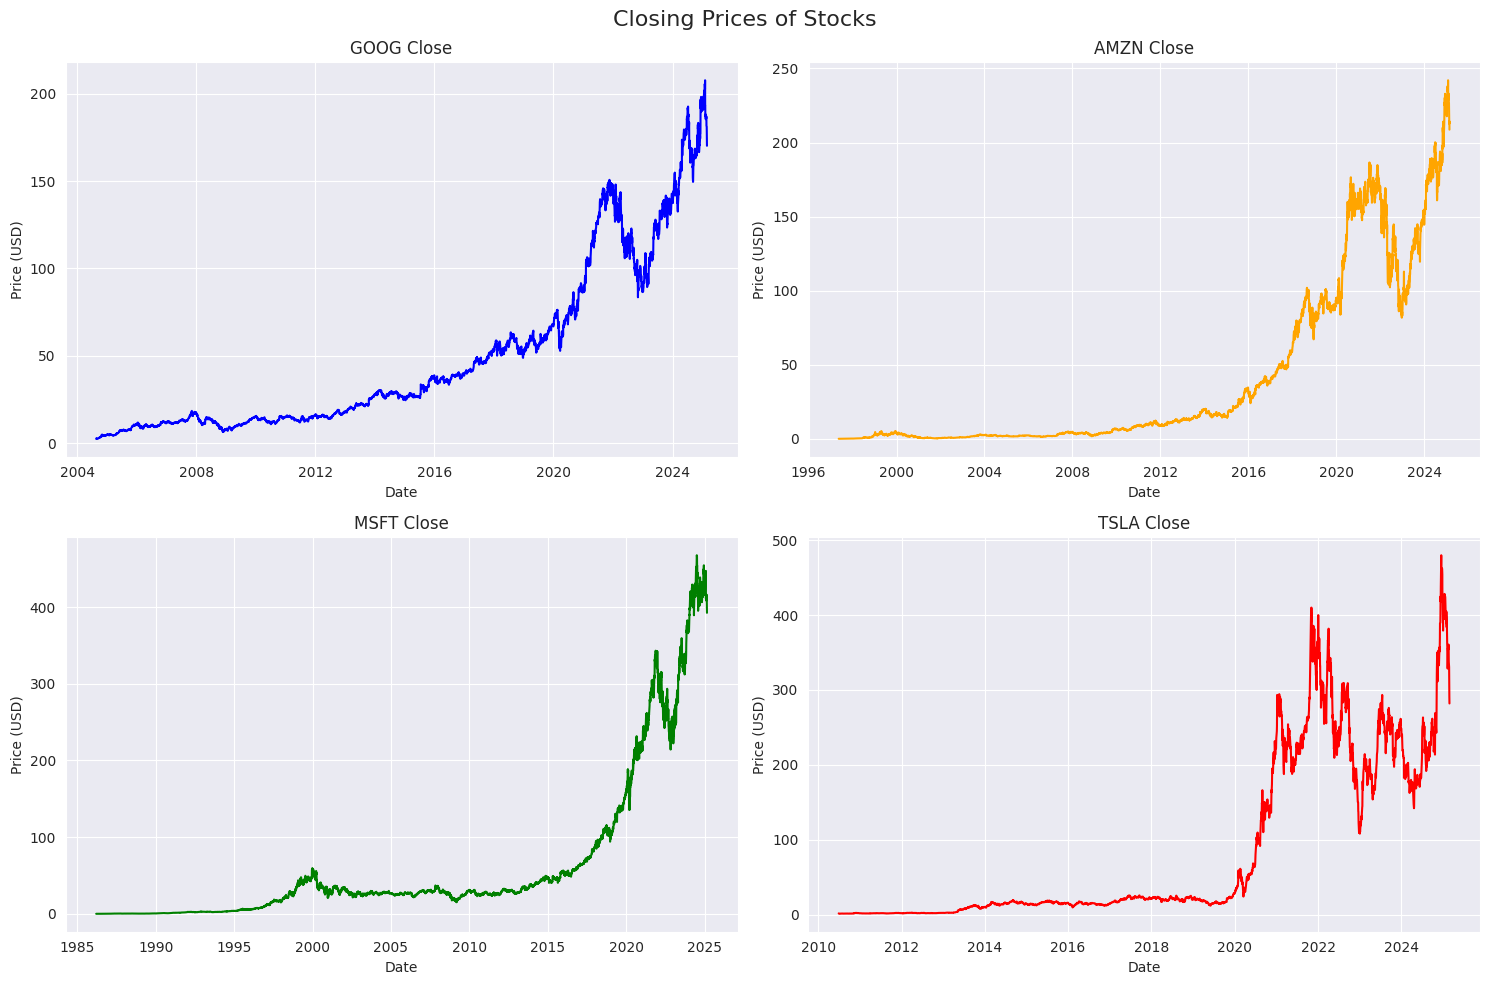

In [15]:
# Plot Closing Prices
plot_stock_data(stock_pandas, metric="Close")

1. All four tech companies have experienced dramatic growth in their share prices, particularly since 2020, suggesting the pandemic and subsequent digital transformation accelerated their valuations.

2. Microsoft shows the longest-term sustained growth pattern (since 1985), demonstrating remarkable resilience through multiple economic cycles and tech transformations.

3. Tesla exhibits the most volatility among these stocks, with extreme price swings since 2020, suggesting higher risk alongside its growth potential.

4. The timing of major price increases differs between companies - Amazon began significant growth earlier (around 2016) while Microsoft's most dramatic rise started around 2019.

5. Despite different founding dates and business models, all four companies reached their highest historical price points in the 2023-2024 period, indicating the strong tech market conditions in this timeframe, probably due to the rise AI and LLMs.

An area plot with facets kinda makes it easier to see the trend, difference and similarity in the stock prices

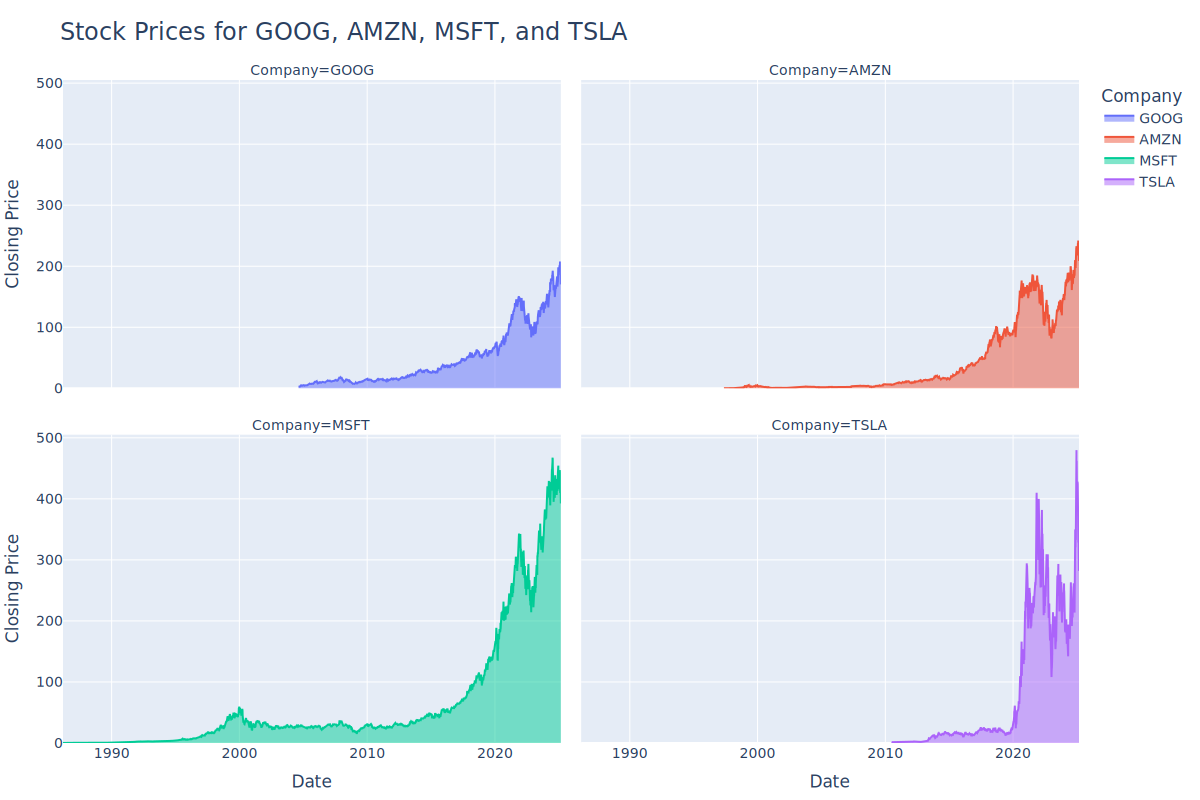

In [16]:
# Combine stock data into a single DataFrame
df_list = []
for ticker, data in stock_pandas.items():
    data["Ticker"] = ticker  # Add ticker column
    df_list.append(data)

df = pd.concat(df_list)  # Merge all stock DataFrames

# Ensure date is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Plot area chart with facet column
fig = px.area(df, x='Date', y='Close', color='Ticker',
              facet_col='Ticker', facet_col_wrap=2,  # Arrange in a 2x2 grid
              labels={'Date': 'Date', 'Close': 'Closing Price', 'Ticker': 'Company'},
              title='Stock Prices for GOOG, AMZN, MSFT, and TSLA')

fig.update_layout(
    width=1200,
    height=800,
    title_font_size=24,
    font_size=14,
    margin=dict(l=50, r=50, t=80, b=50),
    showlegend=True
)

fig.show('svg')

#### **Trading Volume of Stocks**

Trading volume refers to the total number of shares that were traded during a given period. It is an important indicator of market activity and liquidity. High trading volumes often suggest strong investor interest in a stock.

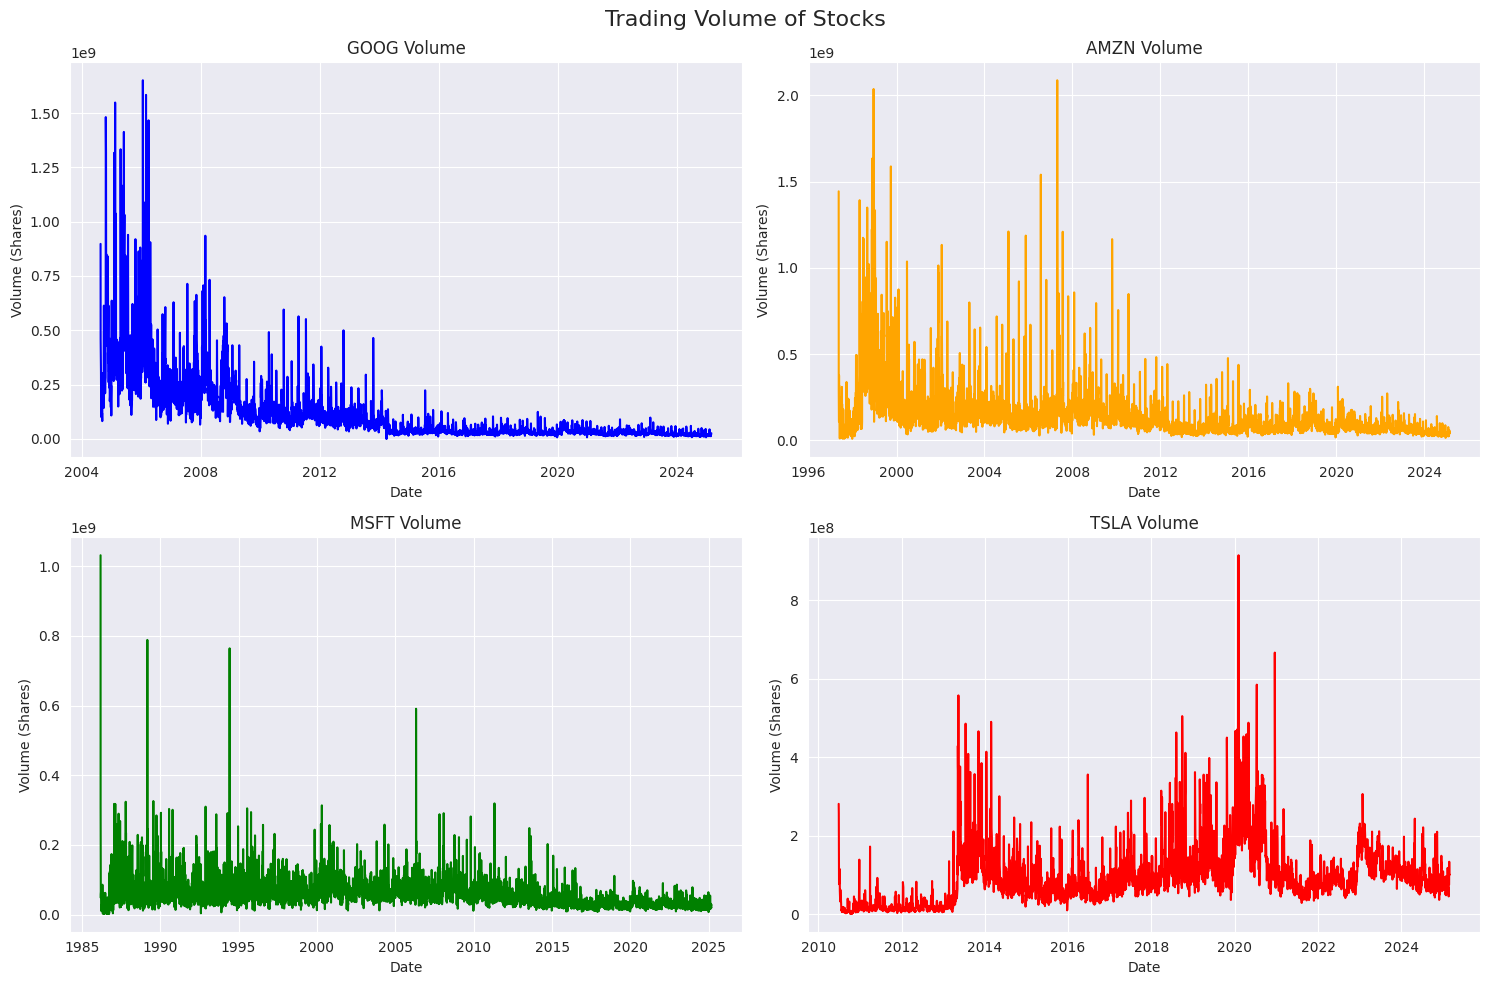

In [17]:
# Plot Volume
plot_stock_data(stock_pandas, metric="Volume")

1. Trading volumes for all four tech stocks have generally declined over time from their earlier peaks, despite their prices increasing (as shown in the previous charts). This suggests greater market maturity and potentially less speculative trading in these stocks over time.

2. Google and Amazon show notably high trading volumes in their earlier years (2004-2008 for Google, 1998-2004 for Amazon), likely corresponding to periods after their IPOs when market participants were establishing positions and price discovery was most active.

3. Microsoft has had several distinct volume spikes throughout its much longer trading history (since 1985), with its highest volume occurring at the very beginning of the chart, possibly during the early tech boom.

4. Tesla's trading volume operates on a different scale (10^8 vs 10^9 for the others) but shows consistent volatility with significant spikes around 2013, 2018-2020, and 2022, aligning with periods of major company announcements and stock price volatility.

5. Despite their price appreciation, all stocks show decreasing trading liquidity in recent years (2020-2024), which contrasts with their price performance during the same period. This could indicate stronger investor conviction and fewer shares changing hands despite higher valuations.

#### **Average Daily Stock Return**

Daily stock return measures the percentage change in a stock's price from one trading day to the next. It is calculated as the difference between the closing price of the current day and the closing price of the previous day, divided by the closing price of the previous day, expressed as a percentage. This metric helps investors understand the short-term performance of a stock and assess its price movements. Positive returns indicate price appreciation, while negative returns indicate depreciation. Daily returns are fundamental for analyzing trends, calculating volatility, and evaluating the risk and reward of holding a stock over time.

In [18]:
volatility_data = {}

# Compute daily returns and annualized volatility for each stock
for ticker in ['GOOG', 'AMZN', 'MSFT', 'TSLA']:
    df = stock_pandas[ticker]
    df['Daily Return'] = df['Adj Close'].pct_change()  # Compute daily returns
    
    # Calculate annualized volatility
    volatility = df['Daily Return'].std()
    annualized_volatility = volatility * np.sqrt(252)
    
    # Store volatility
    volatility_data[ticker] = annualized_volatility

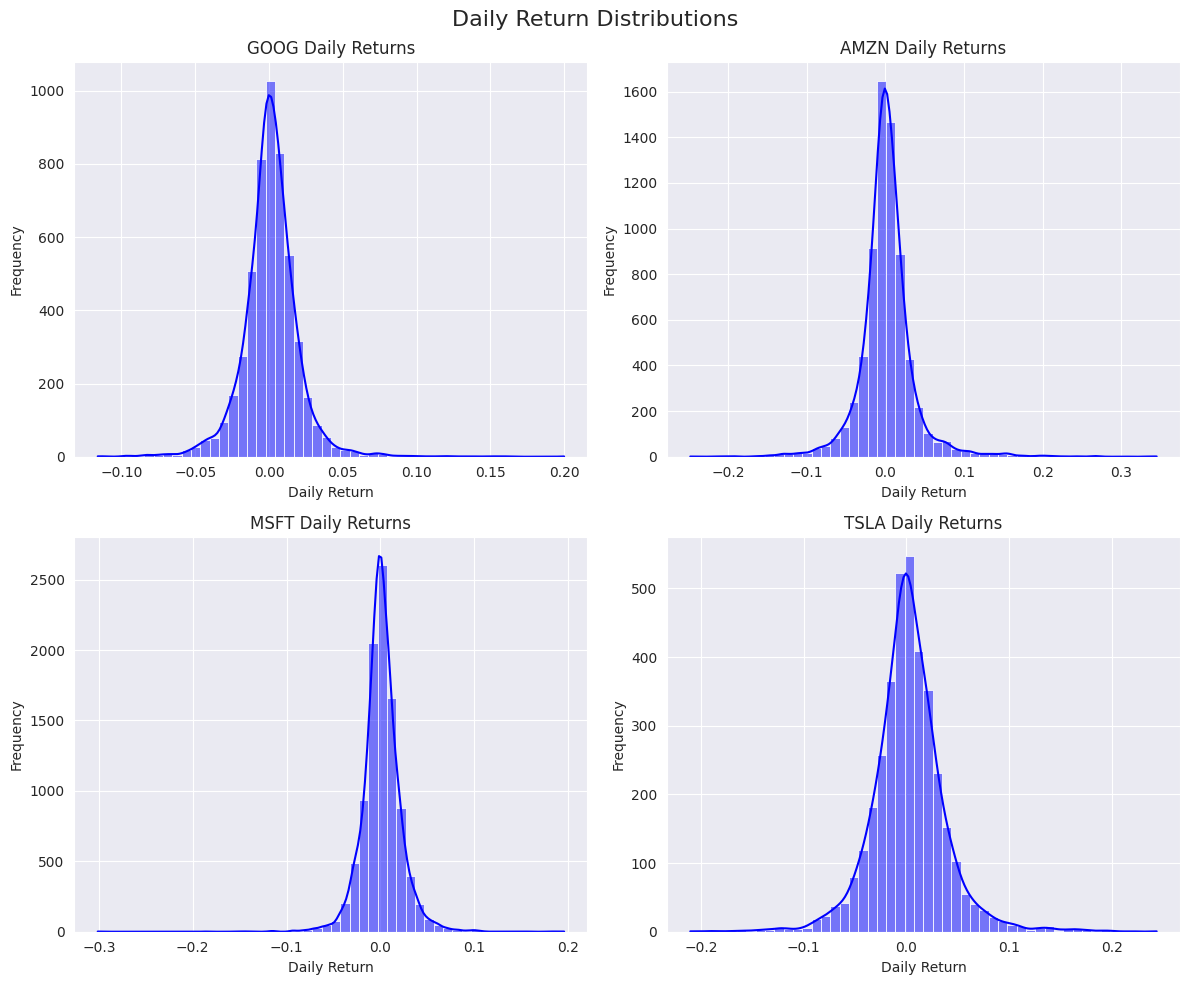

In [19]:
# Create a figure with 2x2 subplots for histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Daily Return Distributions", fontsize=16)

# Tickers and corresponding axes positions
tickers = ['GOOG', 'AMZN', 'MSFT', 'TSLA']
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

# Loop through stocks to plot histograms
for ticker, pos in zip(tickers, positions):
    df = stock_pandas[ticker]
    sns.histplot(df['Daily Return'].dropna(), kde=True, bins=50, ax=axes[pos], color="blue")
    axes[pos].set_title(f"{ticker} Daily Returns")
    axes[pos].set_xlabel("Daily Return")
    axes[pos].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

1. Tesla (TSLA) shows the widest distribution of daily returns, indicating significantly higher volatility than the other three stocks. Its distribution has fatter tails, suggesting more frequent extreme price movements in both directions.

2. Microsoft (MSFT) displays the narrowest and tallest distribution, centered very tightly around zero, suggesting it has historically been the most stable of the four stocks with smaller daily price fluctuations.

3. All four distributions show slight negative skewness (longer tails on the left side), indicating that extreme negative returns are more common than extreme positive returns, a common feature in equity markets.

4. Amazon (AMZN) shows a wider distribution than Google (GOOG) and Microsoft, but narrower than Tesla, placing it as the second most volatile stock among these four.

5. The range of daily returns differs significantly across companies: Microsoft's returns typically stay within ±0.1 (10%), while Tesla frequently experiences daily moves of ±0.15 (15%) or more, explaining why Tesla might appear more attractive to short-term traders seeking volatility but less attractive to risk-averse investors.

#### **Volatility Based on Daily Closing Prices**

Volatility refers to the degree of variation in a stock's price over time, typically measured by the standard deviation of its daily returns. High volatility indicates that a stock's price experiences large and frequent fluctuations, while low volatility suggests more stable and predictable price movements. Volatility is a key measure of risk, as it reflects the uncertainty associated with a stock's future performance. Investors often use volatility to assess the potential for significant price swings and to make informed decisions about portfolio diversification and risk management.

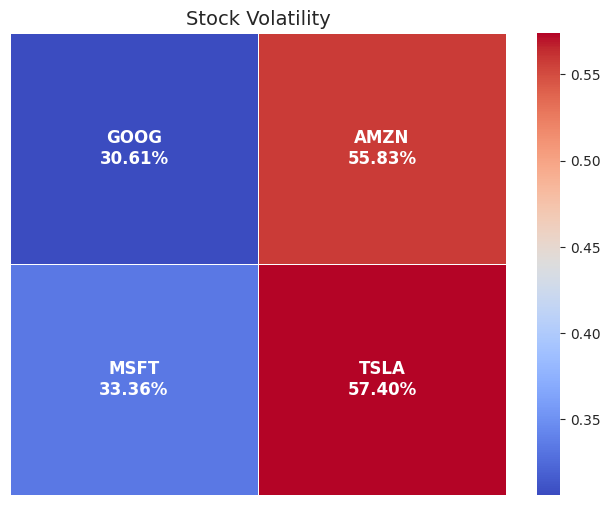

In [20]:
# Convert to a 2x2 DataFrame for the heatmap
volatility_matrix = pd.DataFrame([
    [volatility_data['GOOG'], volatility_data['AMZN']],
    [volatility_data['MSFT'], volatility_data['TSLA']]
], index=['GOOG', 'MSFT'], columns=['AMZN', 'TSLA'])

# Plot the 2x2 heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(volatility_matrix, annot=False, cmap="coolwarm", linewidths=0.5, fmt=".2%")

# Remove axis labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

# Add stock names inside the boxes
for i in range(volatility_matrix.shape[0]):
    for j in range(volatility_matrix.shape[1]):
        value = f"{list(volatility_data.keys())[i * 2 + j]}\n{volatility_matrix.iloc[i, j]:.2%}"
        ax.text(j + 0.5, i + 0.5, value, ha='center', va='center', fontsize=12, color="white", fontweight='bold')

plt.title("Stock Volatility", fontsize=14)
plt.show()

The stock volatility heatmap confirms and quantifies what the daily return distributions suggested:

Tesla is the most volatile stock of the group with 57.40% volatility, closely followed by Amazon at 55.83%. This explains why both stocks showed wider distributions in the previous chart.

Google (30.61%) and Microsoft (33.36%) exhibit significantly lower volatility, with Google being the most stable of the four. These values align with Microsoft's narrower distribution and taller peak we observed in the daily returns chart.

This clear volatility pattern creates a natural segmentation among these tech giants: Tesla and Amazon form a high-volatility pair (>55%), while Google and Microsoft form a moderate-volatility pair (∼30-33%).

The substantial difference in volatility (nearly double) between these two groups would significantly impact investment strategies - Tesla and Amazon would likely appeal to investors with higher risk tolerance seeking greater returns, while Google and Microsoft would attract those preferring more stable growth.

#### **Correlation Between Different Stock Closing Prices**

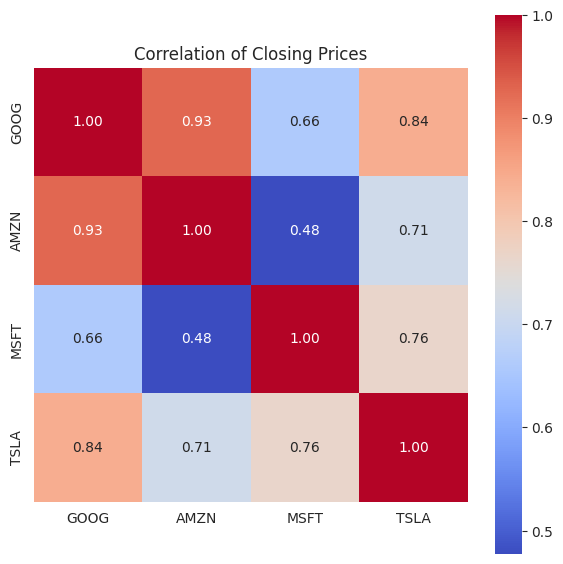

In [21]:
closing_prices = pd.DataFrame({stock: df['Close'] for stock, df in stock_pandas.items()})

plt.figure(figsize=(7, 7))

# Heatmap for Closing Prices Correlation
sns.heatmap(closing_prices.corr(), annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation of Closing Prices')

plt.show()

Google and Amazon show the strongest correlation (0.93) among all pairs

Microsoft shows the weakest correlations with the other stocks, particularly with Amazon (0.48)

Tesla maintains moderate to strong correlations with all three other stocks (0.84 with Google, 0.71 with Amazon, 0.76 with Microsoft)

### **Moving Average of Various Stocks**

Moving averages are statistical tools used to smooth out price data by creating a constantly updated average price over a specific period, such as 50 or 200 days. They help identify trends by filtering out short-term fluctuations and highlighting the underlying direction of a stock's price movement. Common types include the Simple Moving Average (SMA) and the Exponential Moving Average (EMA). Moving averages are widely used in technical analysis to generate buy or sell signals, such as when a short-term moving average crosses above or below a long-term moving average. They provide valuable insights into market trends and potential support or resistance levels.

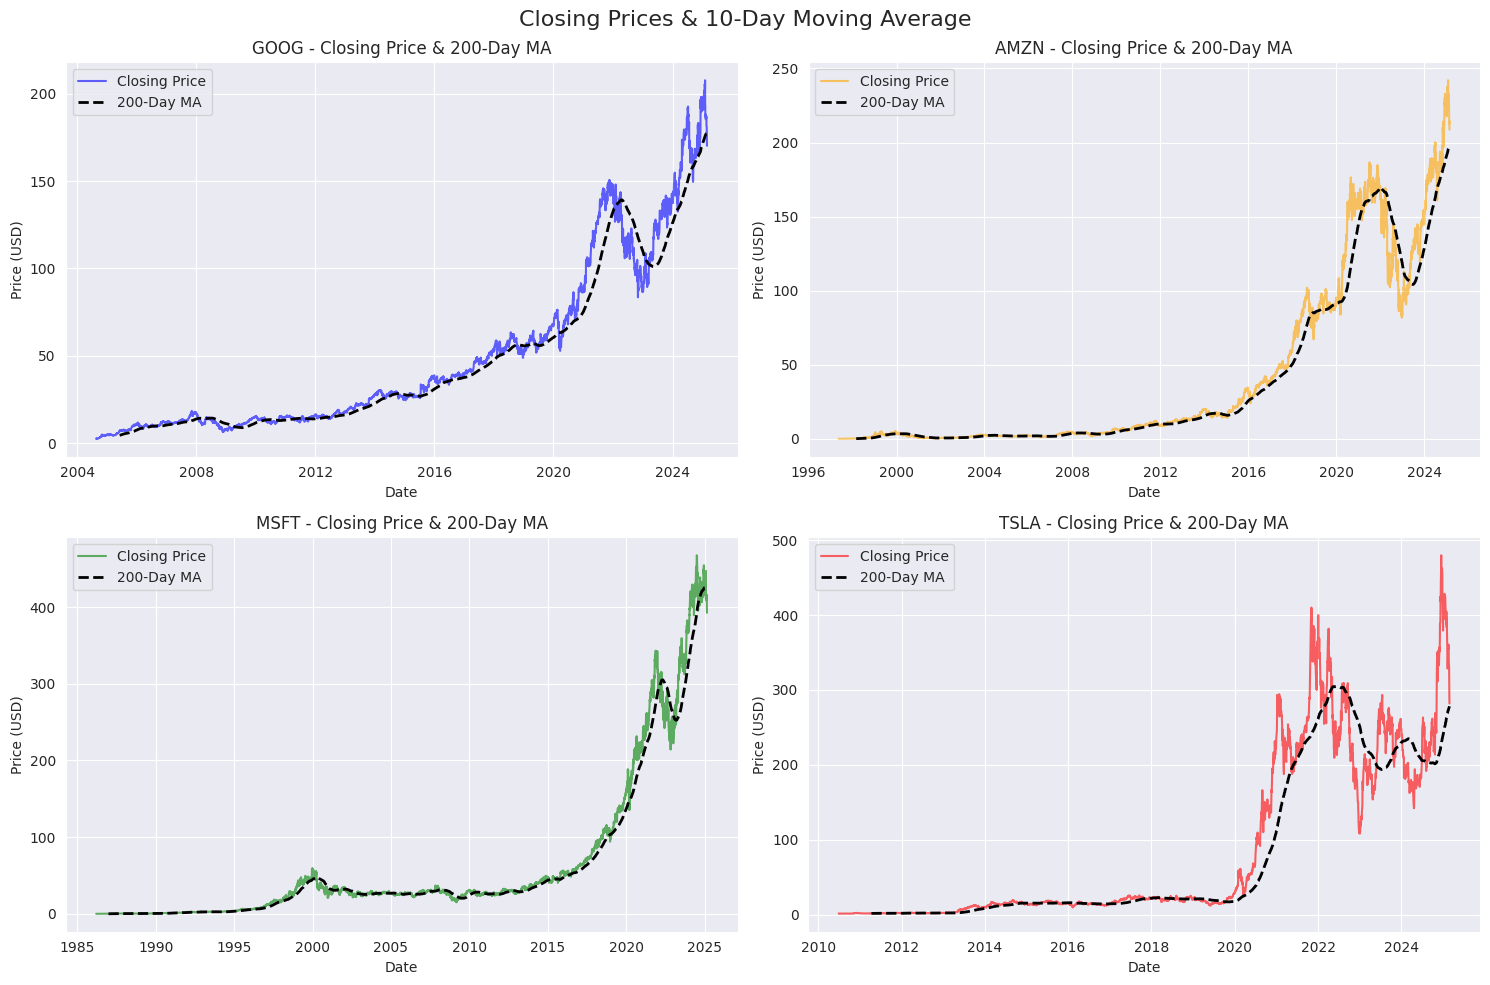

In [22]:
# Compute the 200-Day moving average for each stock
for stock in stock_pandas:
    stock_pandas[stock]['200-Day MA'] = stock_pandas[stock]['Close'].rolling(window=200).mean()

# Create a 2x2 grid for plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Closing Prices & 10-Day Moving Average', fontsize=16)

# List of stocks and corresponding subplot positions
stocks = list(stock_pandas.keys())
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]
colors = ['blue', 'orange', 'green', 'red']

# Plot each stock
for stock, pos, color in zip(stocks, positions, colors):
    ax = axes[pos]
    df = stock_pandas[stock]
    
    # Plot original closing price
    ax.plot(df['Date'], df['Close'], color=color, alpha=0.6, linestyle='-', label='Closing Price')

    # Plot 10-day moving average
    ax.plot(df['Date'], df['200-Day MA'], color='black', linewidth=2, linestyle='--', label='200-Day MA')
    
    ax.set_title(f'{stock} - Closing Price & 200-Day MA')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price (USD)')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

1. Tesla shows the most dramatic deviation from its 200-day moving average, particularly in 2020-2024, with price swings frequently moving far above and below the smoothed trend line. This confirms Tesla's previously identified high volatility (57.40%).

2. Google and Microsoft display the most consistent price trends relative to their moving averages, with prices tracking closely to their 200-day MAs and fewer extreme deviations, supporting their lower volatility measurements.

3. Amazon experienced significant deviations from its moving average during 2020-2022, showing substantial price swings during the pandemic and post-pandemic periods, but has returned to a more consistent uptrend in 2023-2024.

4. All four stocks are currently trading above their 200-day moving averages, indicating positive momentum as of early 2025, though Tesla shows the most recent dramatic upswing above its MA.

5. The charts reveal different recovery patterns after market downturns - Microsoft and Google show smoother recoveries, while Tesla and Amazon demonstrate more volatile recovery patterns with larger price swings during rebounds.